In [1]:
!pip install lightgbm==3.3.2
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.9 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.0.0
    Uninstalling lightgbm-4.0.0:
      Successfully uninstalled lightgbm-4.0.0
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (18.1 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
d

In [2]:
import lightgbm
lightgbm.__version__

'3.3.2'

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44544 (\N{HANGUL SYLLABLE GEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


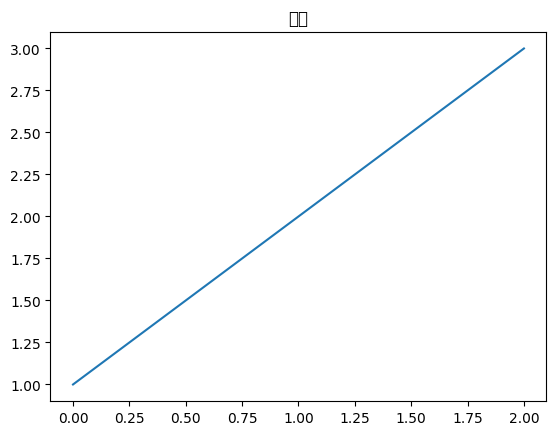

In [3]:
import matplotlib.pyplot as plt
plt.rc("font", family="NanumGothic") # 라이브러리 불러오기와 함께 한번만 실행

plt.plot([1, 2, 3])
plt.title("한글")
plt.show()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 0. 라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)


# 1. data 불러오기

In [4]:
bike_df = pd.read_csv('/content/drive/MyDrive/멀티캠퍼스/data/bike_sharing/train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [5]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [6]:
# 문자열을 datetime 타입으로 변경.
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


# 2. data 가공 & EDA

In [7]:
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis = 1, inplace = True)

bike_df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2


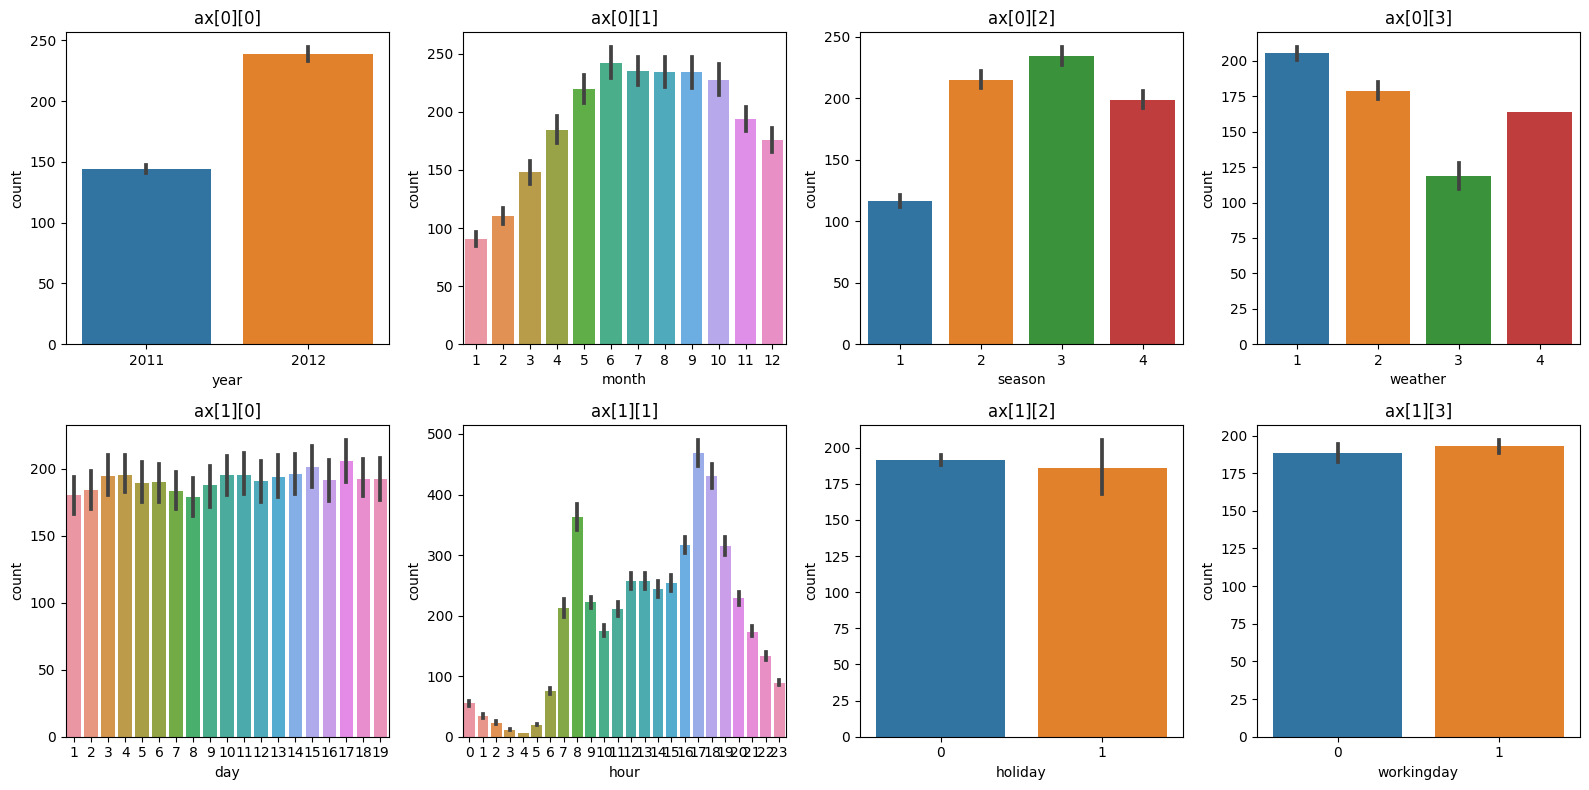

In [8]:
# 시각화 그래프 반복문 써서 한번에 그리기
cat_features = ['year', 'month','season','weather','day', 'hour', 'holiday','workingday']

fig, ax = plt.subplots(figsize = (16, 8), ncols = 4, nrows = 2)
for i, feature in enumerate(cat_features):
    row = int(i/4) # 몫(0, 1)
    col = i%4 # 나머지 0, 1, 2, 3

    sns.barplot(x = feature, y = 'count', data = bike_df, ax = ax[row][col])
    ax[row][col].set_title(f'ax[{row}][{col}]')

plt.tight_layout()
plt.show()

# 3. 평가 지표 구현
- RMSLE : scikit-learn 에서는 미제공
- RMSLE 함수 만듦

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log값 변환 시 NaN 등의 이슈로 log()사용 안함, 대신log1p() 사용
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# mean_squared_error() 이용해서 RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MAE, RMSE, RMSLE 를 모두 계산
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

# 4. 로그변환, 피처 인코딩, 모델 학습

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# 정규화, 표준화 작업 선진행 해줘야 함
y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state = 11)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7620, 12), (3266, 12), (7620,), (3266,))

In [11]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)
evaluate_regr(y_test, pred)

RMSLE: 1.176, RMSE: 143.308, MAE: 107.367


- 368 ~ 374p : 모델 성능 업그레이드 내용

# 5. 모델 평가

In [12]:
def get_top_error_data(y_test, pred, n_tops = 5):
    result_df = pd.DataFrame(y_test.values, columns = ['real_count'])
    result_df['prediction_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['prediction_count'])

    print(result_df.sort_values('diff', ascending =False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  prediction_count   diff
537          835             213.0  622.0
2860         809             194.0  615.0
1259         784             179.0  605.0
2098         731             142.0  589.0
887          968             406.0  562.0


<Axes: >

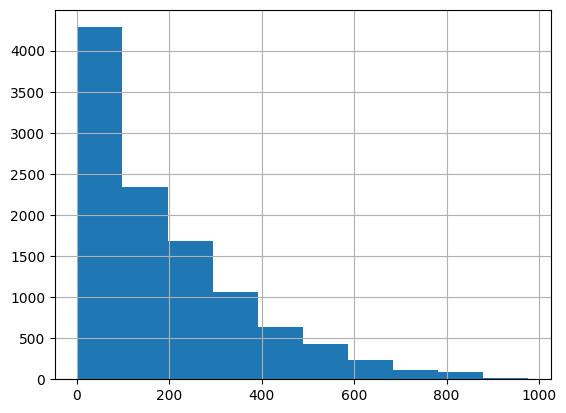

In [13]:
y_target.hist()

# 6. 종속변수를 로그변환

<Axes: >

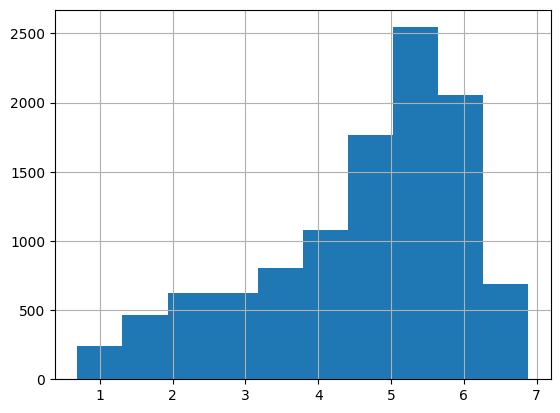

In [14]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

# 7. 모델 재구축

In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
# 다시 학습 & 예측!

y_target_log = np.log1p(y_target)
X_features = bike_df.drop(['count'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size = 0.3, random_state = 11)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 세트의 타깃값을 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값도 스케일 원상복구
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.027, RMSE: 161.615, MAE: 108.537


- 각 피쳐의 회귀 계수 값 시각화

<Axes: >

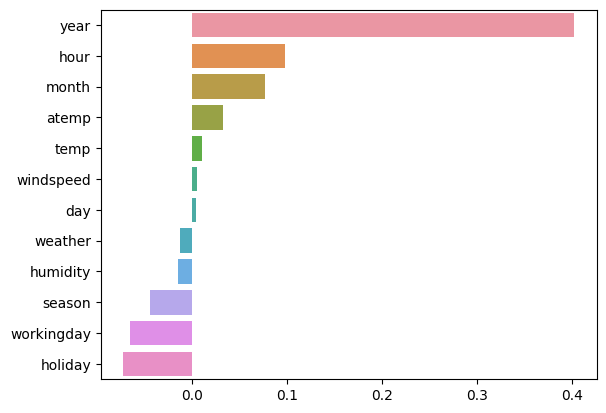

In [16]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

# 8. 변수 인코딩 변환

In [17]:
# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])

# 9. 모델 재구축 2
- 기존 인코딩 변환
- 3개 모델 비교 분석

In [19]:
# 테스트/훈련 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size = 0.3, random_state = 0)

# 보관하면 좋은 메서드🔥
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):  #지수변환
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:  # 지수변환 요청
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###', model.__class__.__name__, '###')
    evaluate_regr(y_test, pred)

# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


<Axes: >

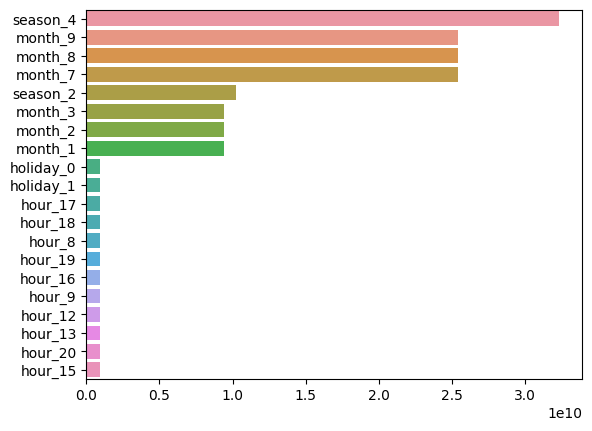

In [20]:
coef = pd.Series(lr_reg.coef_, index = X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y= coef_sort.index)

# 10. 모델 재구축 3

In [41]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.202, MAE: 31.175
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.332, MAE: 32.747
### XGBRegressor ###
RMSLE: 0.342, RMSE: 51.732, MAE: 31.251
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029
